In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0   0.672419 -0.009077  0.192170  1.695966 -0.195252 -0.599612 -0.017373   
  1   0.811960  0.343581  0.357912  0.152355 -1.127350  0.038317 -0.352109   
  2   0.246834 -0.349528  0.792130  1.375016  0.674282 -2.030126 -0.914461   
  3   1.442866  1.036876  0.417392  0.232447  0.502174 -0.800543 -0.369563   
  4   0.845326 -0.265877 -0.210111  0.201492 -0.377052 -1.014420 -0.092909   
  5   0.284563 -0.424168 -0.303410  0.070930 -0.126862 -0.659336  0.282326   
  6   0.870376  0.469980  0.449448 -0.547386  0.165846 -0.072682 -0.079893   
  7   0.529614  0.880265  0.386542  0.406918 -0.319667 -0.147067  0.479515   
  8   0.203505  0.099571 -1.417766 -0.715168  0.003407 -0.547410 -0.396567   
  9  -0.431602  0.022065 -0.170511  0.239408  0.657102 -0.933458  1.130006   
  10  0.758394 -0.800459 -0.190222  0.402810  0.170775 -0.800538 -0.890656   
  11 -0.311773  1.006114 -0.480364  0.774291 -0.251849 -1.389804  0.003943   
  12  0.782647 -0.446671  0.157527 -0.170691 -0.225653 -0.238093  0.099712   
  13  0.315814  0.146888 -0.559267  0.384648  0.237883 -0.590813  0.156854   
  14 -0.279698  0.409610 -0.517897 -0.156051  0.770191  0.000954  0.339993   
  15  0.006958 -0.000765  0.572894  0.210053  0.160194 -0.596503  0.059341   
  16 -0.033075 -0.395403  0.258419  0.876485 -0.551145  0.140889  0.174636   
  17  1.021797 -0.187658  0.237756  0.008927 -0.705546  0.324572 -0.065518   
  18  0.748072 -0.073781 -0.240052 -0.303498 -0.779890 -1.057938 -0.543000   
  19  0.164374 -0.053278  0.675075 -0.362959  0.323746 -0.251032  0.763100   
  20  0.295073  0.109545  0.509482  0.618698  0.060138 -0.049368  0.297988   
  21 -0.188390  0.088005 -0.146454  0.767878 -0.266377 -0.884900  0.309447   
  22  1.233913  0.500201  0.830993 -0.156738 -0.118937 -0.740159  0.129461   
  23 -0.127542  0.413696  0.365660 -0.304186 -0.723908 -1.160937 -0.609412   
  24  1.078371  0.601919 -0.625598 -0.413367 -0.258777 -1.023927 -0.195100   
1 0   1.315447 -0.271947  0.153410  0.725589  0.806004  0.302937  0.439205   
  1   1.052224  1.301116 -0.314954 -0.203314  0.101320 -0.544564 -0.687079   
  2   0.527050  0.373269 -0.613703  0.506884  0.404329 -0.426216  0.176939   
  3   0.620579 -0.169774 -0.212469  0.945156  1.404692 -0.547927 -0.163567   
  4   0.804835  0.284198 -0.456913  1.021882  1.172534 -0.031029 -0.854293   

            X8        X9       X10  ...       X94       X95       X96  \
0 0   0.337358 -0.066332  0.003512  ... -0.664314 -0.504317 -0.641969   
  1  -0.088044 -0.579245 -0.538434  ...  0.233164 -0.167095  0.633427   
  2  -0.178117 -0.152853 -0.649992  ...  0.035446 -0.012148  1.238115   
  3  -0.801967  0.380678  0.956252  ... -0.578124  0.712540  1.010190   
  4  -0.966911  0.160480  0.067907  ...  0.109617 -0.119830  0.083812   
  5   0.296372  1.236076  0.296910  ...  0.189863  0.465216  0.469263   
  6   0.621802  0.317209  0.434444  ...  0.086626 -0.174516  0.574997   
  7   0.012527 -0.306592 -0.246089  ... -0.370497 -0.055958 -0.345418   
  8   0.752171 -0.090769  0.592224  ... -0.344931 -0.148585  0.201347   
  9   1.617762  1.050160  0.180481  ...  0.743183  1.024364  0.195435   
  10 -0.555709  0.253846  0.022183  ...  0.246598 -0.296855  0.006502   
  11  0.856776  0.444372 -0.072523  ... -0.227045 -0.866149 -0.585753   
  12 -0.851949  0.018185 -0.274648  ...  0.126339 -0.432982 -0.608581   
  13 -0.109411  0.123073  0.863331  ...  0.317278  0.432468 -0.472278   
  14 -0.629076 -0.188481 -0.079301  ... -0.770297 -1.019796  0.038655   
  15  0.222916  0.423757  0.001213  ...  0.027185 -0.208586  1.631445   
  16  0.357680  0.779386  0.637906  ...  0.128294 -0.710184  0.086725   
  17  0.104262  0.414370  0.823518  ...  0.755786 -0.560641 -0.578283   
  18 -0.590704  0.190399  0.020383  ... -0.310457 -0.678472  0.688071   
  19  1.165927  0.362081  0.894971  ... -0.238402 -0.137386  1.443532   
  20 -0.308237 -0.459489 -0.492146  ...  0.195420  0.866537 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
D  1.170258  0.034822  33.606703  1.338931e-247  1.102007  1.238508


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



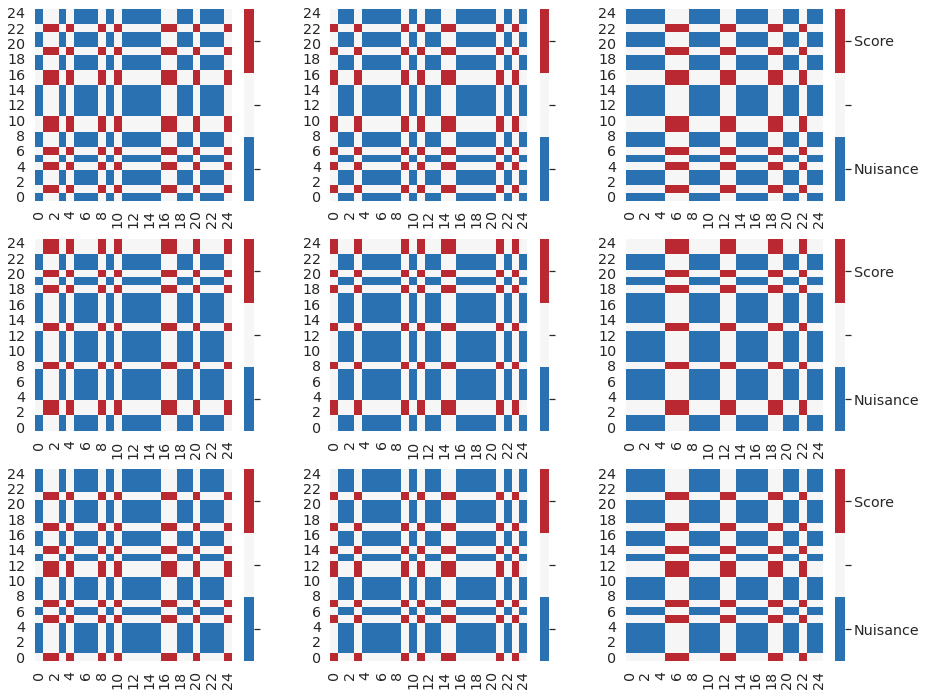

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



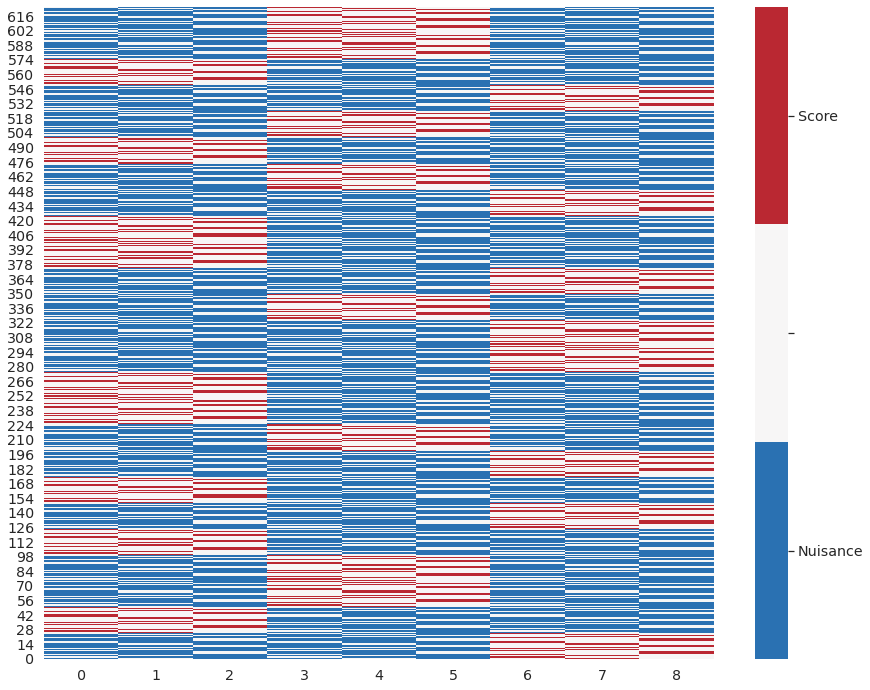

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])